<a href="https://colab.research.google.com/github/anishasahu/fem-helmholtz-eqn/blob/main/notebooks/2d_soln_neumann_sommerfeld_conditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install gmsh wandb
!apt-get update && apt-get install -y libglu1-mesa

In [ ]:
import wandb
from google.colab import userdata
key = userdata.get('WANDB_API_KEY')

wandb.login(key=key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anishasahu (anishasahu-the-university-of-manchester) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import gmsh
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jvp, h1vp, hankel1
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import plotly.graph_objects as go
from scipy.interpolate import interp1d

In [ ]:
def create_mesh(num_elements, inner_radius=1.0, outer_radius=2.0):
    """
    Creates a 2D quadrilateral mesh for a circular region using Gmsh.

    Parameters:
    num_elements (int): Number of elements along the radial direction.
    inner_radius (float): Radius of the inner boundary.
    outer_radius (float): Radius of the outer boundary.

    Returns:
    tuple: (element size, node coordinates, element connectivity)
    """
    # Initialize Gmsh
    gmsh.initialize(sys.argv)

    # Compute approximate element size
    radial_distance = outer_radius - inner_radius
    h = radial_distance / num_elements

    # Create a new model
    gmsh.model.add("circular_region")

    # Define the inner and outer circles
    inner_circle = gmsh.model.occ.addCircle(0, 0, 0, inner_radius)
    inner_loop = gmsh.model.occ.addCurveLoop([inner_circle])

    outer_circle = gmsh.model.occ.addCircle(0, 0, 0, outer_radius)
    outer_loop = gmsh.model.occ.addCurveLoop([outer_circle])

    # Define the surface region between the two circles
    surface = gmsh.model.occ.addPlaneSurface([outer_loop, inner_loop])

    # Synchronize the CAD representation with Gmsh
    gmsh.model.occ.synchronize()

    # Set meshing algorithm to quadrilateral elements
    gmsh.model.mesh.setAlgorithm(2, surface, 8)
    gmsh.model.mesh.setRecombine(2, surface)

    # Set maximum mesh size
    gmsh.option.setNumber("Mesh.MeshSizeMax", h)

    # Generate the mesh
    gmsh.model.mesh.generate(2)

    # Extract mesh node coordinates and element connectivity
    node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
    elem_types, elem_tags, elem_node_tags = gmsh.model.mesh.getElements(2)

    # Process node coordinates
    coords = node_coords.reshape(-1, 3)[:, :2]
    nodes = np.array(coords)

    # Identify quadrilateral elements
    elements = None
    for i in range(len(elem_node_tags)):
            elements = elem_node_tags[i].reshape(-1, 4) - 1  # Adjust indices for zero-based indexing

    # Finalize Gmsh
    gmsh.finalize()

    return h, nodes, elements

def shape_functions(xi, eta):
    """
    Computes shape functions and their derivatives for quadrilateral elements.

    Parameters:
    xi, eta (float): Local coordinates in the reference element.

    Returns:
    tuple: (Shape functions, Gradients of shape functions)
    """
    bases = np.array([
        (1 - xi) * (1 - eta) / 4,  # phi1
        (1 + xi) * (1 - eta) / 4,  # phi2
        (1 + xi) * (1 + eta) / 4,  # phi3
        (1 - xi) * (1 + eta) / 4   # phi4
    ])

    grad = np.array([
        [-(1 - eta) / 4,  (1 - eta) / 4,  (1 + eta) / 4, -(1 + eta) / 4],  # dphi/dxi
        [-(1 - xi) / 4, -(1 + xi) / 4,  (1 + xi) / 4,  (1 - xi) / 4]       # dphi/deta
    ])

    return bases, grad

# Use 2-point Gauss quadrature
gauss_points, gauss_weights = np.polynomial.legendre.leggauss(2)

def element_matrices(nodal_coords):
    """
    Computes the element stiffness and mass matrices using Gauss quadrature.

    Parameters:
    nodal_coords (ndarray): Coordinates of the element nodes.

    Returns:
    tuple: (Element stiffness matrix, Element mass matrix)
    """
    Ke = np.zeros((4, 4))
    Me = np.zeros((4, 4))

    for i, xi in enumerate(gauss_points):
        for j, eta in enumerate(gauss_points):
            bases, grad = shape_functions(xi, eta)

            # Compute Jacobian matrix
            jacobian = grad @ nodal_coords
            det_jacobian = np.linalg.det(jacobian)
            inv_jacobian = np.linalg.inv(jacobian)

            # Compute derivatives in global coordinates
            dbasis_dx = inv_jacobian @ grad

            # Compute integration weight
            weight = gauss_weights[i] * gauss_weights[j]

            # Assemble element matrices
            for m in range(4):
                for n in range(4):
                    Ke[m, n] += (dbasis_dx[:, m] @ dbasis_dx[:, n]) * det_jacobian * weight
                    Me[m, n] += bases[m] * bases[n] * det_jacobian * weight

    return Ke, Me

def boundary_matrices(k, nodal_coords, is_inner_boundary=False):
    """
    Computes boundary matrices for the Neumann and Sommerfeld boundary conditions
    for a boundary element in 2D.

    Parameters:
    k (float): Wavenumber
    nodal_coords (ndarray): Coordinates of the element nodes (shape 4x2)
    is_inner_boundary (bool): True if this is on the inner boundary (for Neumann condition)
    theta (float or array): Incident angle(s) in radians

    Returns:
    tuple: (Neumann vector N_e, Sommerfeld matrix S_e)
    """

    # Initialize boundary matrices
    N_e = np.zeros(4, dtype=complex)
    S_e = np.zeros((4, 4), dtype=complex)

    X = nodal_coords[:, 0]
    Y = nodal_coords[:, 1]
    theta = np.arctan2(Y, X)

    # For 2D quadrilateral elements, boundary integrals are computed along edges
    # We will use 2-point Gauss quadrature along the boundary edge
    if is_inner_boundary:
        # For inner boundary (Neumann condition)
        # We need to determine which edge is on the inner boundary
        # For a circular domain, we can identify points on inner boundary by their distance from origin

        # Identify nodes on inner boundary (should be 2 nodes)
        node_distances = np.sqrt(np.sum(nodal_coords**2, axis=1))
        inner_nodes_idx = np.argsort(node_distances)[:2]  # Get indices of two closest nodes

        # Pairs of local edge indices for a quadrilateral
        edge_nodes = [[0, 1], [1, 2], [2, 3], [3, 0]]

        # Find which edge corresponds to inner boundary
        inner_edge = None
        for i, (n1, n2) in enumerate(edge_nodes):
            if n1 in inner_nodes_idx and n2 in inner_nodes_idx:
                inner_edge = i
                break

        if inner_edge is not None:
            # Map local edge to parametric space
            if inner_edge == 0:  # Bottom edge (eta = -1)
                xi_points = gauss_points
                eta_points = [-1.0] * len(gauss_points)
                jacobian_multiplier = 0.5  # Length of edge in parametric space
            elif inner_edge == 1:  # Right edge (xi = 1)
                xi_points = [1.0] * len(gauss_points)
                eta_points = gauss_points
                jacobian_multiplier = 0.5
            elif inner_edge == 2:  # Top edge (eta = 1)
                xi_points = gauss_points[::-1]  # Reverse to maintain correct orientation
                eta_points = [1.0] * len(gauss_points)
                jacobian_multiplier = 0.5
            else:  # Left edge (xi = -1)
                xi_points = [-1.0] * len(gauss_points)
                eta_points = gauss_points[::-1]
                jacobian_multiplier = 0.5

            # Integrate along the edge
            for i, (xi, eta) in enumerate(zip(xi_points, eta_points)):
                # Compute shape functions and their derivatives
                bases, grad = shape_functions(xi, eta)

                # Compute physical coordinates at this integration point
                phys_coords = bases @ nodal_coords

                # Compute Jacobian of mapping from reference to physical space
                jacobian = grad @ nodal_coords

                # Compute outward normal vector
                if inner_edge == 0:  # Bottom edge
                    tangent = np.array([jacobian[0, 0], jacobian[0, 1]])
                    normal = np.array([-tangent[1], tangent[0]])  # Rotate tangent by 90 degrees
                elif inner_edge == 1:  # Right edge
                    tangent = np.array([jacobian[1, 0], jacobian[1, 1]])
                    normal = np.array([tangent[1], -tangent[0]])
                elif inner_edge == 2:  # Top edge
                    tangent = np.array([-jacobian[0, 0], -jacobian[0, 1]])
                    normal = np.array([-tangent[1], tangent[0]])
                else:  # Left edge
                    tangent = np.array([-jacobian[1, 0], -jacobian[1, 1]])
                    normal = np.array([tangent[1], -tangent[0]])

                # Normalize the normal vector
                normal = normal / np.linalg.norm(normal)

                # Compute measure of edge in physical space (dl)
                edge_jacobian = np.linalg.norm(tangent) * jacobian_multiplier
                weight = gauss_weights[i]

                # Calculate contribution for each theta value
                x, y = phys_coords

                for t_idx, t_val in enumerate(theta):
                    # Compute incident wave derivative in normal direction
                    # For A_in = exp(ik·r) = exp(ik(x*cos(θ) + y*sin(θ)))
                    # ∂A_in/∂n = ik(cos(θ)*n_x + sin(θ)*n_y)*exp(ik·r)
                    incident_phase = k * (x * np.cos(t_val) + y * np.sin(t_val))
                    incident_derivative = (1j * k * (np.cos(t_val) * normal[0] + np.sin(t_val) * normal[1]) *
                                          np.exp(1j * incident_phase))

                    # Compute contribution to Neumann vector: N_i = ∫_Γ φ_i * ∂A_in/∂n dΓ
                    for j in range(4):
                        N_e[j] += bases[j] * incident_derivative * edge_jacobian * weight

    else:
        # For outer boundary (Sommerfeld condition)
        # Identify nodes on outer boundary (should be 2 nodes)
        node_distances = np.sqrt(np.sum(nodal_coords**2, axis=1))
        outer_nodes_idx = np.argsort(node_distances)[-2:]  # Get indices of two farthest nodes

        # Pairs of local edge indices for a quadrilateral
        edge_nodes = [[0, 1], [1, 2], [2, 3], [3, 0]]

        # Find which edge corresponds to outer boundary
        outer_edge = None
        for i, (n1, n2) in enumerate(edge_nodes):
            if n1 in outer_nodes_idx and n2 in outer_nodes_idx:
                outer_edge = i
                break

        if outer_edge is not None:
            # Map local edge to parametric space
            if outer_edge == 0:  # Bottom edge (eta = -1)
                xi_points = gauss_points
                eta_points = [-1.0] * len(gauss_points)
                jacobian_multiplier = 0.5
            elif outer_edge == 1:  # Right edge (xi = 1)
                xi_points = [1.0] * len(gauss_points)
                eta_points = gauss_points
                jacobian_multiplier = 0.5
            elif outer_edge == 2:  # Top edge (eta = 1)
                xi_points = gauss_points[::-1]
                eta_points = [1.0] * len(gauss_points)
                jacobian_multiplier = 0.5
            else:  # Left edge (xi = -1)
                xi_points = [-1.0] * len(gauss_points)
                eta_points = gauss_points[::-1]
                jacobian_multiplier = 0.5

            # Integrate along the edge
            for i, (xi, eta) in enumerate(zip(xi_points, eta_points)):
                # Compute shape functions
                bases, grad = shape_functions(xi, eta)

                # Compute Jacobian of mapping
                jacobian = grad @ nodal_coords

                # Compute tangent vector at this point
                if outer_edge == 0:
                    tangent = np.array([jacobian[0, 0], jacobian[0, 1]])
                elif outer_edge == 1:
                    tangent = np.array([jacobian[1, 0], jacobian[1, 1]])
                elif outer_edge == 2:
                    tangent = np.array([-jacobian[0, 0], -jacobian[0, 1]])
                else:
                    tangent = np.array([-jacobian[1, 0], -jacobian[1, 1]])

                # Compute measure of edge in physical space (dl)
                edge_jacobian = np.linalg.norm(tangent) * jacobian_multiplier

                # Compute contribution to Sommerfeld matrix: S_ij = ∫_Γ φ_i * φ_j * ik dΓ
                weight = gauss_weights[i]
                for m in range(4):
                    for n in range(4):
                        S_e[m, n] += bases[m] * bases[n] * 1j * k * edge_jacobian * weight

    return N_e, S_e

def assembly(nodes, elements, k, inner_radius=1.0, outer_radius=2.0):
    """
    Assembles the global system matrices for the 2D Helmholtz equation with boundary conditions.

    Parameters:
    nodes (ndarray): Global node coordinates
    elements (ndarray): Element connectivity matrix
    k (float): Wavenumber
    inner_radius (float): Radius of inner boundary
    outer_radius (float): Radius of outer boundary
    theta (float or array): Incident angle(s) in radians

    Returns:
    tuple: (System matrix A, RHS vector b)
    """
    n_nodes = len(nodes)
    n_elements = len(elements)

    # Initialize global matrices
    K = np.zeros((n_nodes, n_nodes), dtype=complex)
    M = np.zeros((n_nodes, n_nodes), dtype=complex)
    S = np.zeros((n_nodes, n_nodes), dtype=complex)
    b = np.zeros(n_nodes, dtype=complex)

    # Assemble element matrices
    for e in range(n_elements):
        # Get element node indices
        element_nodes = elements[e]

        # Get coordinates of element nodes
        element_coords = nodes[element_nodes]

        # Compute element stiffness and mass matrices
        Ke, Me = element_matrices(element_coords)

        # Assemble into global matrices
        for i in range(4):
            for j in range(4):
                K[element_nodes[i], element_nodes[j]] += Ke[i, j]
                M[element_nodes[i], element_nodes[j]] += Me[i, j]

    # Identify boundary elements
    boundary_elements = []
    for e in range(n_elements):
        element_nodes = elements[e]
        element_coords = nodes[element_nodes]

        # Calculate distances of nodes from origin
        distances = np.sqrt(np.sum(element_coords**2, axis=1))

        # Check if this element has nodes on inner boundary
        if np.any(np.isclose(distances, inner_radius, rtol=1e-10)):
            boundary_elements.append((e, True))  # e is element index, True means inner boundary

        # Check if this element has nodes on outer boundary
        if np.any(np.isclose(distances, outer_radius, rtol=1e-10)):
            boundary_elements.append((e, False))  # False means outer boundary

    # Process boundary elements
    for e, is_inner in boundary_elements:
        element_nodes = elements[e]
        element_coords = nodes[element_nodes]

        # Compute boundary matrices
        N_e, S_e = boundary_matrices(k, element_coords, is_inner)

        # Assemble Neumann vector (inner boundary)
        if is_inner:
            for i in range(4):
              for t_idx in range(len(theta)):
                        b[element_nodes[i]] += N_e[i]

        # Assemble Sommerfeld matrix (outer boundary)
        else:
            for i in range(4):
                for j in range(4):
                    S[element_nodes[i], element_nodes[j]] += S_e[i, j]

    # Form final system: A = -K + k²M + S
    A = -K + (k**2) * M + S

    return A, b

def analytical_solution(r, k, theta, m_terms=50):
    """
    Computes the analytical solution of the 2D Helmholtz equation in polar coordinates.

    Parameters:
        r (array): Radial coordinates.
        k (float): Wavenumber.
        theta (array): Angular coordinates.
        m_terms (int): Number of terms in the summation.

    Returns:
        X, Y, U: Cartesian coordinates and solution values for visualization.
    """
    u_analytical = np.zeros((len(r), len(theta)), dtype=np.complex128)

    for i, r_val in enumerate(r):
        for j, theta_val in enumerate(theta):
            u_sum = 0 * 1j

            for m in range(-m_terms, m_terms + 1):
                # Compute Bessel and Hankel function derivatives
                j_prime = jvp(m, k * r_val).astype(np.complex128)
                h_prime = h1vp(m, k * r_val)
                h_m = hankel1(m, k * r_val)

                coefficient = j_prime / h_prime * h_m
                u_sum += (1j**m) * coefficient * np.exp(1j * m * theta_val)

            u_analytical[i, j] = u_sum

    # Convert polar to Cartesian coordinates for plotting
    R, Theta = np.meshgrid(r, theta, indexing='ij')
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)

    return X, Y, u_analytical

def solve_helmholtz_fem(N, k, inner_radius=1.0, outer_radius=2.0):
    """
    Solves the Helmholtz equation using the Finite Element Method (FEM).

    Parameters:
    N (int): Number of elements in the mesh.
    k (float): Wave number.
    inner_radius (float, optional): Radius of the inner boundary (default is 1.0).
    outer_radius (float, optional): Radius of the outer boundary (default is 2.0).

    Returns:
    tuple: Nodes and numerical solution values.
    """
    # Generate mesh: h (element size), nodes (coordinates), elements (connectivity)
    h, nodes, elements = create_mesh(N, inner_radius, outer_radius)

    # Assemble system matrix A and right-hand side vector b
    A, b = assembly(nodes, elements, k)

    # Solve the linear system for numerical solution u_num
    u_num = np.linalg.solve(A, b)

    return nodes, u_num

def plot_combined_solution_3d(ax, r, theta, nodes, elements, u_num, k, inner_radius, outer_radius, num_points=100):
    """
    Plots both the numerical FEM solution and the analytical solution on the same 3D plot.
    The analytical solution is shown in red, and the numerical solution in green.
    """
    # Plot numerical solution (green)
    for element in elements:
        x = nodes[element, 0]
        y = nodes[element, 1]
        z = u_num[element]  # Numerical solution values
        verts = [list(zip(x, y, z))]
        poly = Poly3DCollection(verts, alpha=0.6, color='green')
        ax.add_collection3d(poly)

    X, Y, U = analytical_solution(r, k, theta)

    # Plot analytical solution (red)
    ax.plot_surface(X, Y, U, color='red', alpha=0.5)

    # Set axis labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u(x,y)')
    ax.set_title("Numerical (Green) vs Analytical (Red) Solution")

def plot_solutions_combined(r, theta, nodes, elements, u_num, k, inner_radius=1.0, outer_radius=2.0, figsize=(10, 7)):
    """
    Generates a 3D plot overlaying the numerical and analytical solutions.
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    plot_combined_solution_3d(ax, r, theta, nodes, elements, u_num, k, inner_radius, outer_radius)
    plt.tight_layout()
    return fig

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


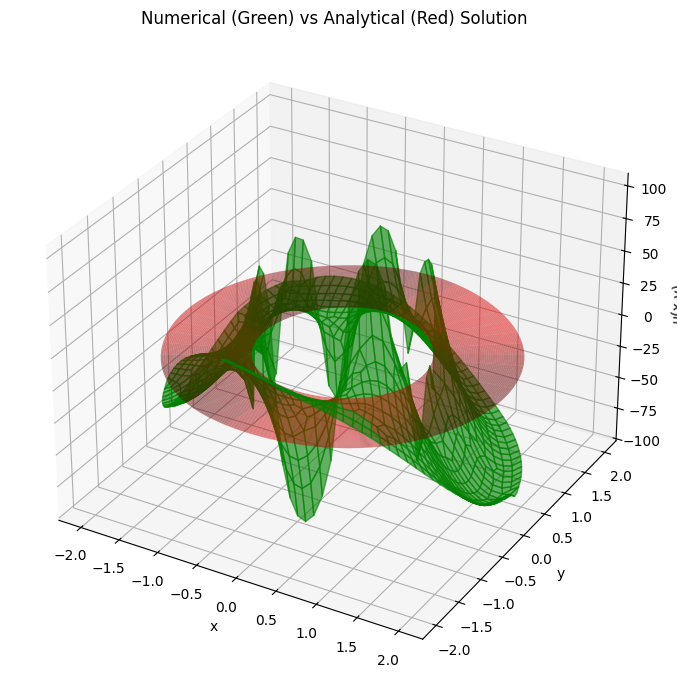

In [ ]:
# Define problem parameters
k = 2  # Wavenumber
N = 10  # Number of elements in the radial direction

# Radial grid for analytical solution
r = np.linspace(1.0, 2.0, 100)
theta = np.linspace(0, 2*np.pi, 100)

# Generate the finite element mesh
h, nodes, elements = create_mesh(N)

# Solve the Helmholtz equation using the FEM approach
nodes, u_num = solve_helmholtz_fem(N, k)

# Plot and compare the numerical and analytical solutions
fig = plot_solutions_combined(r, theta, nodes, elements, u_num, k)

# Display the (non-interactive) plot
plt.show()

In [ ]:
def compute_L2_error(k, elements, nodes, u_num):
    L2_error = 0.0

    for element in elements:
        # Extract nodal coordinates for the current element
        nodal_coords = nodes[element]
        U = u_num[element]
        error = 0.0

        for i in range(len(gauss_points)):
            xi = gauss_points[i]
            eta = gauss_points[i]
            wi = gauss_weights[i]

            # Compute shape functions and their derivatives in reference coordinates
            basis_fns, grad = shape_functions(xi, eta)

            # Compute the Jacobian matrix and its determinant
            J = grad @ nodal_coords
            detJ = np.linalg.det(J)

            # Map (xi, eta) in reference element to (x, y) in physical element
            x = np.dot(basis_fns, nodal_coords[:, 0])
            y = np.dot(basis_fns, nodal_coords[:, 1])

            # Numerical solution at (x, y)
            Ue = np.dot(basis_fns, U)

            # Analytical solution at (x, y)
            r = r = np.sqrt(x**2 + y**2)
            _, U_exact = analytical_solution(r, k)

            # Accumulate the error
            error += (U_exact - Ue) ** 2 * wi * detJ

        L2_error += error

    return np.sqrt(L2_error)

def convergence_test(k_values, N_values, inner_radius=1.0, outer_radius=2.0):
    """
    Performs a convergence test for different values of k and N.
    Computes the numerical solution and compares it with the analytical solution.
    Plots the log-log error graph to analyze convergence behavior.

    Parameters:
    k_values (list): List of wave numbers to test.
    N_values (list): List of mesh refinements (number of elements across the radius).
    inner_radius (float, optional): Inner boundary radius (default is 1.0).
    outer_radius (float, optional): Outer boundary radius (default is 2.0).
    """
    errors = {k: [] for k in k_values}
    h_values = []

    for N in N_values:
        h, nodes, elements = create_mesh(N, inner_radius, outer_radius)
        h_values.append(h)

        for i, k in enumerate(k_values):
            # Compute numerical solution
            nodes, u_num = solve_helmholtz_fem(N, k)

            # Calculate radial positions of nodes
            r = np.linalg.norm(nodes, axis=1)

            # Compute analytical solution directly at node positions
            u_exact = analytical_solution(r, k, inner_radius, outer_radius)

            # Compute L2 error norm
            error = compute_L2_error(k, elements, nodes, u_num)
            errors[k].append(error)

    # Create figure with appropriate size
    plt.figure(figsize=(10, 6))

    # Plot error curves for each k
    for k in k_values:
        log_h = np.log(h_values)
        log_error = np.log(errors[k])
        slope, intercept = np.polyfit(log_h, log_error, 1)
        print(f"Convergence rate for k = {k}: {slope:.2f}")
        plt.loglog(h_values, errors[k], '-', label=f'k = {k} (slope = {slope:.2f})')

    plt.xlabel('Element Size h')
    plt.ylabel('Relative L2 Error')
    plt.title('Convergence Test: Log-Log Error Plot')
    plt.legend()
    plt.grid(True, which='both', linewidth=0.5)
    plt.tight_layout()

    return errors, h_values

# Define test values for k (wave number) and N (mesh refinement)
k_values = [1, 2, 3, 4, 5, 10, 15, 20]  # Test with different wave numbers
N_values = [1, 2, 5, 10, 15]  # Increasing mesh refinement levels

# Run convergence test
convergence_test(k_values, N_values)

TypeError: object of type 'float' has no len()

In [ ]:
def plot_combined_solution_3d_plotly(r, nodes, elements, u_num, k, inner_radius, outer_radius, num_points=100):
    """
    Creates an interactive 3D plot using Plotly, displaying both the numerical FEM solution and the analytical solution.
    The analytical solution is shown in red, and the numerical solution in green.
    """
    numerical_traces = []

    # Plot numerical solution (green mesh)
    for element in elements:
        x = nodes[element, 0]
        y = nodes[element, 1]
        z = u_num[element]  # Numerical solution values

        numerical_traces.append(go.Mesh3d(
            x=x, y=y, z=z,
            color='green', opacity=0.7,
            alphahull=0
        ))

    # Get analytical solution on radial grid
    r_vals, u_analytical = analytical_solution(r, k, inner_radius, outer_radius)
    theta = np.linspace(0, 2*np.pi, num_points)
    r_grid, theta_grid = np.meshgrid(r_vals, theta)
    x_grid = r_grid * np.cos(theta_grid)
    y_grid = r_grid * np.sin(theta_grid)
    u_grid = np.tile(u_analytical, (num_points, 1))

    # Plot analytical solution (red surface)
    analytical_trace = go.Surface(
        x=x_grid, y=y_grid, z=u_grid,
        colorscale=[[0, 'red'], [1, 'red']],
        opacity=0.2,
        showscale=False
    )

    # Create figure and add traces
    fig = go.Figure(data=numerical_traces + [analytical_trace])
    fig.update_layout(
        scene=dict(
            xaxis_title='x',
            yaxis_title='y',
            zaxis_title='u(x,y)',
        ),
        title="Numerical (Green) vs Analytical (Red) Solution",
    )

    return fig

In [ ]:
# Define problem parameters
k = 5  # Wavenumber
N = 5  # Number of elements in the radial direction

# Radial grid for analytical solution
r = np.linspace(1.0, 2.0, 100)

# Generate the finite element mesh
h, nodes, elements = create_mesh(N)

# Solve the Helmholtz equation using the FEM approach
nodes, u_num = solve_helmholtz_fem(N, k)

# Plot and compare the numerical and analytical solutions
fig = plot_combined_solution_3d_plotly(r, nodes, elements, u_num, k, 1.0, 2.0)

# Display the (non-interactive) plot
plt.show()

In [ ]:
wandb.init(project="fem-helmholtz", entity = "sauravmaheshkar")
wandb.log({"Numerical Solution (Green) vs. Analyitcal Solution (Red) with Dirichlet Conditions": fig})
wandb.finish()